# Classifier

## Import libraries

In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import os
from tqdm.notebook import tqdm, trange
from time import sleep
from torchvision.io import read_image
from torchvision.transforms import ToTensor
from torchvision import transforms
from torchsummary import summary
from torch.utils.data import DataLoader
from torchvision.datasets import ImageFolder
from collections import Counter
import numpy as np
from sklearn.metrics import roc_curve, auc
from sklearn import datasets
from sklearn.multiclass import OneVsRestClassifier
from sklearn.svm import LinearSVC
from sklearn.preprocessing import label_binarize
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
import pandas as pd


## Functions definition

In [2]:
def get_default_device():
    """Pick GPU if available, else CPU"""
    if torch.cuda.is_available():
        return torch.device('cuda')
    else:
        return torch.device('cpu')
    
def to_device(data, device):
    """Move tensor(s) to chosen device"""
    if isinstance(data, (list,tuple)):
        return [to_device(x, device) for x in data]
    return data.to(device, non_blocking=True)

In [3]:
@torch.no_grad()
def evaluate(model, val_loader):
    model.eval()
    outputs = [model.validation_step(batch) for batch in val_loader]
    return model.validation_epoch_end(outputs)

def fit(epochs, lr, model, train_loader, val_loader, opt_func=torch.optim.SGD):
    history = []
    optimizer = opt_func(model.parameters(), lr, betas=(0.5,0.999))
    for epoch in tqdm(range(epochs), desc = "Current Epoch"):
        # Training Phase 
        model.train()
        train_losses = []
        for batch in tqdm(train_loader, desc = f"Epoch: {epoch}", leave= False):
            optimizer.zero_grad()
            loss = model.training_step(batch)
            train_losses.append(loss)
            loss.backward()
            optimizer.step()
        # Validation phase
        result = evaluate(model, val_loader)
        result['train_loss'] = torch.stack(train_losses).mean().item()
        model.epoch_end(epoch, result)
        history.append(result)
    return history

## Class definition

In [4]:
class DeviceDataLoader():
    """Wrap a dataloader to move data to a device"""
    def __init__(self, dl, device):
        self.dl = dl
        self.device = device
        
    def __iter__(self):
        """Yield a batch of data after moving it to device"""
        for b in self.dl: 
            yield to_device(b, self.device)

    def __len__(self):
        """Number of batches"""
        return len(self.dl)

In [5]:
class Metric():
    def __init__(self, name):
        self.name = name
    
    def eval(self, outputs, labels):
        pass

In [6]:
class Accuracy(Metric):
    
    def eval(self, outputs, labels):
        _, preds = torch.max(outputs, dim=1)
        return torch.tensor(torch.sum(preds == labels).item() / len(preds))

In [7]:
class ImageClassificationBase(nn.Module):
    
    def __init__(self, loss_function, metrics):
        super().__init__()
        self.loss_function = loss_function
        self.metrics = metrics
    
    def training_step(self, batch):
        images, labels = batch 
        out = self(images)                  # Generate predictions
        loss = self.loss_function(out, labels) # Calculate loss
        return loss
    
    def validation_step(self, batch):
        images, labels = batch 
        out = self(images)                    # Generate predictions
        loss = self.loss_function(out, labels)   # Calculate loss
        result = {'val_loss': loss.detach()}
        
        for m in self.metrics:
            result[m.name] = m.eval(out, labels)           # Calculate metrics
            
        return result
        
    def validation_epoch_end(self, outputs):
        batch_losses = [x['val_loss'] for x in outputs]
        epoch_loss = torch.stack(batch_losses).mean()   # Combine losses
        
        result = {'val_loss': epoch_loss.item()}
        
        for m in self.metrics:
            batch = [x[m.name] for x in outputs]
            epoch = torch.stack(batch).mean()      # Combine metrics
            result[m.name] = epoch.item()
            
        return result
    
    def epoch_end(self, epoch, result):
        out = f"Epoch [{epoch}]"
        vals = list(result.keys())
        for v in vals:
            out += f", {v}: {result[v]:.4f}"
        print(out)
        

In [8]:
class Net(ImageClassificationBase):
    
    def __init__(self, loss_function, metrics, out_size):
        super().__init__(loss_function, metrics)
        self.conv1 = nn.Conv2d(in_channels=1, out_channels=32, kernel_size=3, stride=1)
        self.pool1 = nn.MaxPool2d(kernel_size=3,stride=2, padding=1)
        self.norm1 = nn.BatchNorm2d(32)
        self.conv2 = nn.Conv2d(in_channels=32, out_channels=64, kernel_size=3, stride=1)
        self.pool2 = nn.MaxPool2d(kernel_size=3,stride=2, padding=1)
        self.norm2 = nn.BatchNorm2d(64)
        self.conv3 = nn.Conv2d(in_channels=64, out_channels=128, kernel_size=3, stride=1)
        self.pool3 = nn.MaxPool2d(kernel_size=3, stride=2, padding=1)
        self.norm3 = nn.BatchNorm2d(128)
        self.fc1 = nn.Linear(in_features=128*5*5, out_features=256)
        #self.fc2 = nn.Linear(in_features=256, out_features=256)
        self.fc = nn.Linear(256, out_size)

    def forward(self, input):
        output = self.norm1(self.pool1(F.relu(self.conv1(input))))
        output = self.norm2(self.pool2(F.relu(self.conv2((output)))))
        output = self.norm3(self.pool3(F.relu(self.conv3((output)))))
        output = output.view(-1, 128*5*5)
        output = F.relu(self.fc1(output))
        #output = F.relu(self.fc2(output))
        output = self.fc(output)
        output = F.softmax(input = output)
        return output

    """def __init__(self, loss_function, metrics, out_size):
        super().__init__(loss_function, metrics)
        self.conv1 = nn.Conv2d(in_channels=1, out_channels=32, kernel_size=3, stride=1, padding=1)
        self.conv2 = nn.Conv2d(in_channels=32, out_channels=64, kernel_size=3, stride=1, padding = 1)
        self.norm1 = nn.BatchNorm2d(64)
        self.pool1 = nn.MaxPool2d(kernel_size=2)
        self.drop1 = nn.Dropout2d(p=0.25)
        self.conv3 = nn.Conv2d(in_channels=64, out_channels=128, kernel_size=3, stride=1, padding=1)
        self.conv4 = nn.Conv2d(in_channels=128, out_channels=256, kernel_size=3, stride=1)
        self.norm2 = nn.BatchNorm2d(256)
        self.pool2 = nn.MaxPool2d(kernel_size=2)
        self.drop2 = nn.Dropout2d(p=0.25)
        self.flatten = nn.Flatten()
        self.fc1 = nn.Linear(in_features=256*11*11, out_features=1024)
        self.drop3 = nn.Dropout2d(p=0.5)
        self.fc = nn.Linear(1024, out_size)

    def forward(self, input):
        output = F.relu(self.conv1(input))
        output = F.relu(self.conv2(output))
        output = self.drop1(self.pool1(self.norm1(output)))
        output = F.relu(self.conv3(output))
        output = F.relu(self.conv4(output))
        output = self.drop2(self.pool2(self.norm2(output)))
        output = self.flatten(output)
        output = F.relu(self.fc1(output))
        output = self.fc(self.drop3(output))
        output = F.softmax(input = output)
        return output"""

## Variables definition

In [9]:
device = get_default_device()
models_directory = "models"
metrics_directory = "metrics"
metrics_name = "metrics.csv"
dataset_name = "Fer2013_Aug_Disgust_uniform_e_03_identity"
train_df_path = f"../datasets/{dataset_name}/train"
test_df_path = f"../datasets/{dataset_name}/test"

batch_size = 64

## Dataset loading

In [10]:
df_train = ImageFolder(root=train_df_path, transform=transforms.Compose([transforms.Grayscale(num_output_channels=1),
                                     transforms.ToTensor()]))
df_test = ImageFolder(root=test_df_path, transform=transforms.Compose([transforms.Grayscale(num_output_channels=1),
                                     transforms.ToTensor()]))

In [11]:
train_dl = DeviceDataLoader(DataLoader(df_train, batch_size=batch_size, shuffle=True),device)
test_dl = DeviceDataLoader(DataLoader(df_test, batch_size=batch_size, shuffle=True),device)

In [12]:
classes = df_train.classes
classes

['angry', 'disgust', 'fear', 'happy', 'neutral', 'sad', 'surprise']

In [13]:
counts = dict(Counter(df_train.targets))
print(counts)
weights = np.array(list(counts.values()))
weights = torch.Tensor( min(weights)/weights)
print(weights)

{0: 3995, 1: 1669, 2: 4097, 3: 7215, 4: 4965, 5: 4830, 6: 3171}
tensor([0.4178, 1.0000, 0.4074, 0.2313, 0.3362, 0.3455, 0.5263])


## Model design and Training

In [14]:

loss_function = nn.CrossEntropyLoss(weight = weights)
metrics = [Accuracy("val_acc")]
optimizer = optim.Adam
lr =0.0001
num_epochs = 25

In [15]:
net = Net(loss_function, metrics, len(classes))
net.to(device)
summary(net,(1,48,48))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 32, 46, 46]             320
         MaxPool2d-2           [-1, 32, 23, 23]               0
       BatchNorm2d-3           [-1, 32, 23, 23]              64
            Conv2d-4           [-1, 64, 21, 21]          18,496
         MaxPool2d-5           [-1, 64, 11, 11]               0
       BatchNorm2d-6           [-1, 64, 11, 11]             128
            Conv2d-7            [-1, 128, 9, 9]          73,856
         MaxPool2d-8            [-1, 128, 5, 5]               0
       BatchNorm2d-9            [-1, 128, 5, 5]             256
           Linear-10                  [-1, 256]         819,456
           Linear-11                    [-1, 7]           1,799
Total params: 914,375
Trainable params: 914,375
Non-trainable params: 0
----------------------------------------------------------------
Input size (MB): 0.01
Forward/

C:\Users\Franc\AppData\Local\Temp\ipykernel_5200\3262377354.py:26: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  output = F.softmax(input = output)


In [16]:
history = fit(num_epochs, lr, net, train_dl, test_dl, optimizer)

Current Epoch:   0%|          | 0/25 [00:00<?, ?it/s]

Epoch: 0:   0%|          | 0/468 [00:00<?, ?it/s]

C:\Users\Franc\AppData\Local\Temp\ipykernel_5200\3262377354.py:26: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  output = F.softmax(input = output)


Epoch [0], val_loss: 1.6629, val_acc: 0.4882, train_loss: 1.7556


Epoch: 1:   0%|          | 0/468 [00:00<?, ?it/s]

Epoch [1], val_loss: 1.6266, val_acc: 0.5235, train_loss: 1.6465


Epoch: 2:   0%|          | 0/468 [00:00<?, ?it/s]

Epoch [2], val_loss: 1.6066, val_acc: 0.5391, train_loss: 1.6003


Epoch: 3:   0%|          | 0/468 [00:00<?, ?it/s]

Epoch [3], val_loss: 1.6033, val_acc: 0.5555, train_loss: 1.5663


Epoch: 4:   0%|          | 0/468 [00:00<?, ?it/s]

Epoch [4], val_loss: 1.5922, val_acc: 0.5670, train_loss: 1.5376


Epoch: 5:   0%|          | 0/468 [00:00<?, ?it/s]

Epoch [5], val_loss: 1.5831, val_acc: 0.5845, train_loss: 1.5126


Epoch: 6:   0%|          | 0/468 [00:00<?, ?it/s]

Epoch [6], val_loss: 1.5905, val_acc: 0.5725, train_loss: 1.4875


Epoch: 7:   0%|          | 0/468 [00:00<?, ?it/s]

Epoch [7], val_loss: 1.5947, val_acc: 0.5647, train_loss: 1.4654


Epoch: 8:   0%|          | 0/468 [00:00<?, ?it/s]

Epoch [8], val_loss: 1.5928, val_acc: 0.5794, train_loss: 1.4467


Epoch: 9:   0%|          | 0/468 [00:00<?, ?it/s]

Epoch [9], val_loss: 1.6036, val_acc: 0.5659, train_loss: 1.4287


Epoch: 10:   0%|          | 0/468 [00:00<?, ?it/s]

Epoch [10], val_loss: 1.6067, val_acc: 0.5643, train_loss: 1.4127


Epoch: 11:   0%|          | 0/468 [00:00<?, ?it/s]

Epoch [11], val_loss: 1.5851, val_acc: 0.5789, train_loss: 1.3967


Epoch: 12:   0%|          | 0/468 [00:00<?, ?it/s]

Epoch [12], val_loss: 1.5882, val_acc: 0.5823, train_loss: 1.3831


Epoch: 13:   0%|          | 0/468 [00:00<?, ?it/s]

Epoch [13], val_loss: 1.5887, val_acc: 0.5732, train_loss: 1.3725


Epoch: 14:   0%|          | 0/468 [00:00<?, ?it/s]

Epoch [14], val_loss: 1.5929, val_acc: 0.5705, train_loss: 1.3615


Epoch: 15:   0%|          | 0/468 [00:00<?, ?it/s]

Epoch [15], val_loss: 1.6001, val_acc: 0.5687, train_loss: 1.3516


Epoch: 16:   0%|          | 0/468 [00:00<?, ?it/s]

Epoch [16], val_loss: 1.5896, val_acc: 0.5718, train_loss: 1.3429


Epoch: 17:   0%|          | 0/468 [00:00<?, ?it/s]

Epoch [17], val_loss: 1.5698, val_acc: 0.5829, train_loss: 1.3365


Epoch: 18:   0%|          | 0/468 [00:00<?, ?it/s]

Epoch [18], val_loss: 1.5889, val_acc: 0.5877, train_loss: 1.3297


Epoch: 19:   0%|          | 0/468 [00:00<?, ?it/s]

Epoch [19], val_loss: 1.5958, val_acc: 0.5683, train_loss: 1.3238


Epoch: 20:   0%|          | 0/468 [00:00<?, ?it/s]

Epoch [20], val_loss: 1.5838, val_acc: 0.5611, train_loss: 1.3196


Epoch: 21:   0%|          | 0/468 [00:00<?, ?it/s]

Epoch [21], val_loss: 1.6086, val_acc: 0.5526, train_loss: 1.3152


Epoch: 22:   0%|          | 0/468 [00:00<?, ?it/s]

Epoch [22], val_loss: 1.5986, val_acc: 0.5645, train_loss: 1.3118


Epoch: 23:   0%|          | 0/468 [00:00<?, ?it/s]

Epoch [23], val_loss: 1.5877, val_acc: 0.5661, train_loss: 1.3089


Epoch: 24:   0%|          | 0/468 [00:00<?, ?it/s]

Epoch [24], val_loss: 1.6071, val_acc: 0.5649, train_loss: 1.3045


## Save/Load model

In [17]:
if not os.path.isdir(models_directory):
    os.makedirs(name = models_directory)
model_path = os.path.join(models_directory,f"classifier_{dataset_name}.pt")


In [18]:
torch.save(net.state_dict(), model_path)

In [19]:
net = Net(loss_function, metrics, len(classes))
net.load_state_dict(torch.load(model_path))
net.eval()
net.cuda()

Net(
  (loss_function): CrossEntropyLoss()
  (conv1): Conv2d(1, 32, kernel_size=(3, 3), stride=(1, 1))
  (pool1): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (norm1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (conv2): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1))
  (pool2): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (norm2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (conv3): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1))
  (pool3): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (norm3): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (fc1): Linear(in_features=3200, out_features=256, bias=True)
  (fc): Linear(in_features=256, out_features=7, bias=True)
)

## Model testing

In [20]:
y_test = []
y_scores = []

# since we're not training, we don't need to calculate the gradients for our outputs
with torch.no_grad():
    for data in tqdm(test_dl):
        images, labels = data[0].to(device), data[1].to(device)
        # calculate outputs by running images through the network
        outputs = net(images)

        # the class with the highest energy is what we choose as prediction
        _, predicted = torch.max(outputs.data, 1)

        y_test.extend(labels.tolist())
        y_scores.extend(outputs.tolist())

y_test = np.array(y_test)
y_scores = np.array(y_scores)


  0%|          | 0/11 [00:00<?, ?it/s]

C:\Users\Franc\AppData\Local\Temp\ipykernel_5200\3262377354.py:26: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  output = F.softmax(input = output)


### Network Accuracy

In [21]:
# Overall accuracy

n_test = y_test.shape[0]
predicted = np.argmax(y_scores,axis=1)
mean_acc = np.sum(predicted == y_test) / n_test
class_acc = []

print(f'Overall accuracy: {100 * mean_acc } %')

# Accuracy per class

correct_pred = {classname: 0 for classname in classes}
total_pred = {classname: 0 for classname in classes}

# collect the correct predictions for each class
for label, prediction in zip(y_test, predicted):
    if label == prediction:
        correct_pred[classes[label]] += 1
    total_pred[classes[label]] += 1


# print accuracy for each class
print("Accuracy per class:")
for classname, correct_count in correct_pred.items():
    accuracy = float(correct_count) / total_pred[classname]
    class_acc.append(accuracy)
    print(f'{classname:9s} : {accuracy * 100:.1f} %')

Overall accuracy: 56.42857142857143 %
Accuracy per class:
angry     : 46.0 %
disgust   : 52.0 %
fear      : 33.0 %
happy     : 76.0 %
neutral   : 59.0 %
sad       : 50.0 %
surprise  : 79.0 %


# ROC/AUC

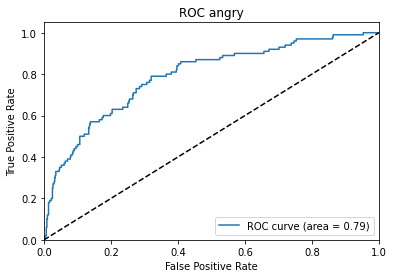

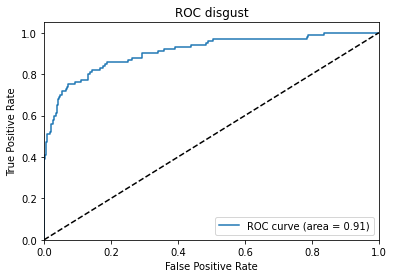

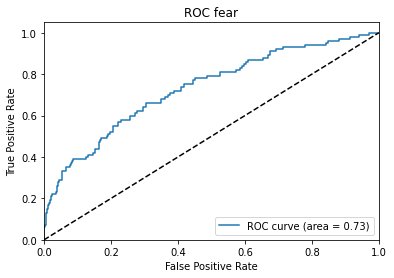

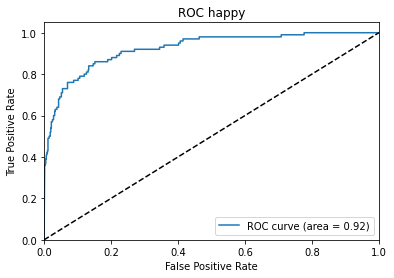

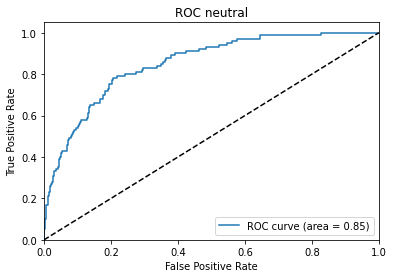

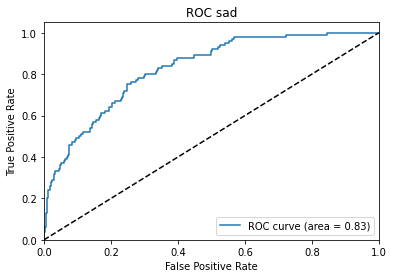

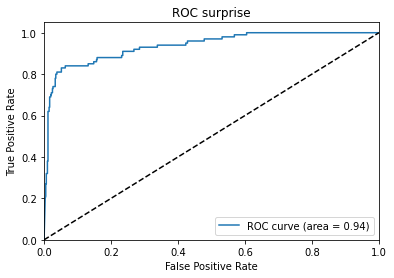

In [22]:


# Compute ROC curve and ROC area for each class
fpr = dict()
tpr = dict()
ths = dict()
roc_auc = dict()
for i,_ in enumerate(classes):
    fpr[i], tpr[i], ths[i] = roc_curve(y_test == i, y_scores[:,i])
    roc_auc[i] = auc(fpr[i], tpr[i])

# Plot of a ROC curve for a specific class
for i,c in enumerate(classes):
    plt.figure()
    plt.plot(fpr[i], tpr[i], label='ROC curve (area = %0.2f)' % roc_auc[i])
    plt.plot([0, 1], [0, 1], 'k--')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title(f'ROC {c}')
    plt.legend(loc="lower right")
    plt.show()

In [23]:
mean_auc = np.mean(list(roc_auc.values()))
print(f"Mean AUC: { mean_auc * 100} %")

print("Per classs AUC:")
for i,c in enumerate(classes):
    print(f'{c:9s} : {roc_auc[i]*100:.2f} %')

Mean AUC: 85.25226190476191 %
Per classs AUC:
angry     : 79.08 %
disgust   : 90.89 %
fear      : 73.08 %
happy     : 92.39 %
neutral   : 85.03 %
sad       : 82.61 %
surprise  : 93.70 %


## Save metrics

In [24]:
columns=["exp name", "mean AUC", "angry AUC", "disgust AUC", "fear AUC", "happy AUC", "neautral AUC", "sad AUC", "surprise AUC", "mean ACC", "angry ACC", "disgust ACC", "fear ACC", "happy ACC", "neautral ACC", "sad ACC", "surprise ACC"]

In [25]:
exp = [dataset_name, mean_auc]
exp += list(roc_auc.values())
exp += [mean_acc]
exp += class_acc

In [28]:
try:
    df = pd.read_csv(os.path.join(metrics_directory, metrics_name),index_col=0)
except FileNotFoundError:
    df = pd.DataFrame(columns = columns)

df_new = pd.DataFrame( np.array([exp]), columns=columns)

df = pd.concat([df,df_new])
df

,exp name,mean AUC,angry AUC,disgust AUC,fear AUC,happy AUC,neautral AUC,sad AUC,surprise AUC,mean ACC,angry ACC,disgust ACC,fear ACC,happy ACC,neautral ACC,sad ACC,surprise ACC
0,Fer2013_Aug_Disgust_E_uniform,0.855057,0.798417,0.889717,0.765533,0.928925,0.834992,0.820217,0.947600,0.567143,0.47,0.52,0.41,0.76,0.53,0.49,0.79
0,Fer2013_uniform,0.859254,0.806867,0.917383,0.739967,0.932842,0.842558,0.835200,0.939958,0.597143,0.47,0.64,0.43,0.76,0.55,0.52,0.81
0,Fer2013_Aug_Disgust_uniform_e_03_identity,0.862043,0.798542,0.905367,0.764433,0.938250,0.850183,0.833917,0.943608,0.580000,0.46,0.58,0.39,0.79,0.58,0.49,0.77
0,Fer2013_Aug_Disgust_uniform_e_03_identity,0.852523,0.790758,0.908850,0.730817,0.923875,0.850300,0.826100,0.936958,0.564286,0.46,0.52,0.33,0.76,0.59,0.50,0.79


In [27]:
if not os.path.isdir(metrics_directory):
    os.makedirs(name = metrics_directory)
df.to_csv(os.path.join(metrics_directory, metrics_name))